In [ ]:
# 1. Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the dataset
url = 'https://raw.githubusercontent.com/Tanvir-yzu/AI_ML-Expert-With-Phitron-Batch-01/main/Machine%20Learning/heart.csv'
data = pd.read_csv(url)

print("First 5 rows:")
print(data.head())
print(f"\nDataset shape: {data.shape}")
print("\nDataset info:")
print(data.info())

First 5 rows:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  

Dataset shape: (918, 12)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
--

In [ ]:
print("\n TASK 2: Data Preprocessing ")


df = data.copy()

# Step 1: Handle missing values
print(df.isnull().sum())


for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

print(df.isnull().sum())

# Step 2: Encode categorical variables
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Step 3: Feature engineering
df['BP_HR_Ratio'] = df['RestingBP'] / (df['MaxHR'] + 1)
df['Chol_Age_Ratio'] = df['Cholesterol'] / (df['Age'] + 1)
df['Risk_Score'] = (df['Oldpeak'] * 2) + (df['Age'] / 10)
df['Cardiac_Stress'] = df['MaxHR'] / (df['RestingBP'] + 1)

# Step 4: Outlier detection and handling
def handle_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
original_shape = df.shape
for col in numeric_cols:
    df = handle_outliers_iqr(df, col)
print(f"Rows removed due to outliers: {original_shape[0] - df.shape[0]}")

# Step 5: Feature scaling
scaler = StandardScaler()
scaling_cols = numeric_cols + ['BP_HR_Ratio', 'Chol_Age_Ratio', 'Risk_Score', 'Cardiac_Stress']
df[scaling_cols] = scaler.fit_transform(df[scaling_cols])

print(f"Final shape: {df.shape}")
print(" Preprocessing completed!")


 TASK 2: Data Preprocessing 
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
Encoded Sex: {'F': np.int64(0), 'M': np.int64(1)}
Encoded ChestPainType: {'ASY': np.int64(0), 'ATA': np.int64(1), 'NAP': np.int64(2), 'TA': np.int64(3)}
Encoded FastingBS: {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}
Encoded RestingECG: {'LVH': np.int64(0), 'Normal': np.int64(1), 'ST': np.int64(2)}
Encoded ExerciseAngina: {'N': np.int64(0), 'Y': np.int64(1)}
Encoded ST_Slope: {'Down': np.int64(0), 'Flat': np.int64(1), 'Up': np.int64(2)}
Rows removed du

In [ ]:

print("\n TASK 3: Pipeline Creation ")


X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak',
                   'BP_HR_Ratio', 'Chol_Age_Ratio', 'Risk_Score', 'Cardiac_Stress']
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features)
    ]
)

print(" Pipeline  created!")


 TASK 3: Pipeline Creation 
Training set: (560, 15)
Test set: (141, 15)
 Pipeline  created!


In [ ]:

print("\n TASK 4: Primary Model Selection ")

print("Selected Model: Random Forest Classifier")
print("\nJustification:")
print("1. Handles both numerical and categorical data effectively")
print("2. Robust to outliers and overfitting through ensemble nature")
print("3. Provides feature importance for interpretability")
print("4. Requires minimal hyperparameter tuning for good performance")
print("5. Works well with the dataset size (918 samples)")





#  base learners
base_learners = [
    ('logistic_reg', LogisticRegression(random_state=42, max_iter=1000)),
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(probability=True, random_state=42)),
    ('gradient_boost', GradientBoostingClassifier(random_state=42)),
    ('xgboost', xgb.XGBClassifier(random_state=42)),
    ('lightgbm', lgb.LGBMClassifier(random_state=42))
]

# Train and evaluate base learners
base_results = {}
print("\nBase Learners Performance:")
for name, model in base_learners:
    # Create pipeline for each base learner
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])


    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

    # Train and evaluate
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    base_results[name] = {
        'pipeline': pipeline,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_accuracy': test_accuracy
    }

    print(f"{name:.<20} CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}, Test: {test_accuracy:.4f}")


#  learners for voting
top_models = [
    ('rf', base_learners[1][1]),  # Random Forest
    ('xgb', base_learners[4][1]), # XGBoost
    ('lgbm', base_learners[5][1]) # LightGBM
]


voting_clf = VotingClassifier(
    estimators=top_models,
    voting='soft'
)

voting_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('voting', voting_clf)
])


voting_cv_scores = cross_val_score(voting_pipeline, X_train, y_train, cv=5, scoring='accuracy')
voting_pipeline.fit(X_train, y_train)
y_pred_voting = voting_pipeline.predict(X_test)
voting_accuracy = accuracy_score(y_test, y_pred_voting)

print(f"Voting Classifier: CV: {voting_cv_scores.mean():.4f} ± {voting_cv_scores.std():.4f}")
print(f"Voting Classifier Test Accuracy: {voting_accuracy:.4f}")



# Define base learners for stacking
base_learners_stack = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBClassifier(random_state=42)),
    ('lgbm', lgb.LGBMClassifier(random_state=42))
]

# Meta-learner
meta_learner = LogisticRegression(random_state=42, max_iter=1000)

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners_stack,
    final_estimator=meta_learner,
    cv=5,
    passthrough=True,
    n_jobs=-1
)

stacking_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('stacking', stacking_clf)
])

# Train and evaluate stacking classifier
stacking_cv_scores = cross_val_score(stacking_pipeline, X_train, y_train, cv=5, scoring='accuracy')
stacking_pipeline.fit(X_train, y_train)
y_pred_stacking = stacking_pipeline.predict(X_test)
stacking_accuracy = accuracy_score(y_test, y_pred_stacking)

print(f"Stacking Classifier: CV: {stacking_cv_scores.mean():.4f} ± {stacking_cv_scores.std():.4f}")
print(f"Stacking Classifier Test Accuracy: {stacking_accuracy:.4f}")

print(" Primary Model Selection")


 TASK 4: Primary Model Selection 
Selected Model: Random Forest Classifier

Justification:
1. Handles both numerical and categorical data effectively
2. Robust to outliers and overfitting through ensemble nature
3. Provides feature importance for interpretability
4. Requires minimal hyperparameter tuning for good performance
5. Works well with the dataset size (918 samples)

Base Learners Performance:
logistic_reg........ CV: 0.8536 ± 0.0322, Test: 0.8156
random_forest....... CV: 0.8536 ± 0.0302, Test: 0.8511
svm................. CV: 0.8482 ± 0.0370, Test: 0.8298
gradient_boost...... CV: 0.8536 ± 0.0268, Test: 0.8865
xgboost............. CV: 0.8446 ± 0.0145, Test: 0.8652
[LightGBM] [Info] Number of positive: 208, number of negative: 240
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

In [ ]:

print("\n TASK 5: Model Training ")

#  (Random Forest)
primary_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

primary_model.fit(X_train, y_train)
y_pred_primary = primary_model.predict(X_test)
primary_accuracy = accuracy_score(y_test, y_pred_primary)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Primary Model Test Accuracy: {primary_accuracy:.4f}")
print("Model Training Successful ")


 TASK 5: Model Training 
Training set size: 560 samples
Test set size: 141 samples
Primary Model Test Accuracy: 0.8511
Model Training Successful 


In [ ]:

print("\n TASK 6: Cross-Validation ")

# Cross-validation
primary_cv_scores = cross_val_score(primary_model, X_train, y_train, cv=5, scoring='accuracy')

for i, score in enumerate(primary_cv_scores, 1):
    print(f"Fold {i}: {score:.4f}")

print(f"Mean CV Accuracy: {primary_cv_scores.mean():.4f} ± {primary_cv_scores.std():.4f}")
print(" Cross-Validation successful ")


 TASK 6: Cross-Validation 
Fold 1: 0.8304
Fold 2: 0.8393
Fold 3: 0.8750
Fold 4: 0.9018
Fold 5: 0.8214
Mean CV Accuracy: 0.8536 ± 0.0302
 Cross-Validation successful 


In [ ]:

print("\n TASK 7: Hyperparameter Tuning ")

#  grid for Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}


for param, values in param_grid.items():
    print(f"{param}: {values}")

# Randomized Search for efficiency
random_search = RandomizedSearchCV(
    primary_model,
    param_grid,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print(f"\nBest Parameters: {random_search.best_params_}")
print(f"Best Cross-Validation Score: {random_search.best_score_:.4f}")
print("Hyperparameter Tuning  Successful")


 TASK 7: Hyperparameter Tuning 
classifier__n_estimators: [100, 200, 300]
classifier__max_depth: [5, 10, 15, None]
classifier__min_samples_split: [2, 5, 10]
classifier__min_samples_leaf: [1, 2, 4]

Best Parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 15}
Best Cross-Validation Score: 0.8643
 Hyperparameter Tuning  Successful


In [ ]:

print("\n TASK 8: Best Model Selection ")

# Compare all models
models_comparison = {
    'Primary (Random Forest)': primary_accuracy,
    'Voting Classifier': voting_accuracy,
    'Stacking Classifier': stacking_accuracy
}

# Add best base model
best_base_name = max(base_results.items(), key=lambda x: x[1]['test_accuracy'])[0]
models_comparison[f'Best Base ({best_base_name})'] = base_results[best_base_name]['test_accuracy']


for name, accuracy in models_comparison.items():
    print(f"{name:<30}: {accuracy:.4f}")

# Select best overall model
best_model_name = max(models_comparison.items(), key=lambda x: x[1])[0]
best_accuracy = models_comparison[best_model_name]

print(f"\n🏆 BEST OVERALL MODEL: {best_model_name}")
print(f"📊 Best Test Accuracy: {best_accuracy:.4f}")

# Get the actual best model
if best_model_name == 'Primary (Random Forest)':
    best_model = primary_model
elif best_model_name == 'Voting Classifier':
    best_model = voting_pipeline
elif best_model_name == 'Stacking Classifier':
    best_model = stacking_pipeline
else:
    # Best base model
    best_model = base_results[best_base_name]['pipeline']

print("TASK 8: Best Model Selection Successfull ")


 TASK 8: Best Model Selection 
Primary (Random Forest)       : 0.8511
Voting Classifier             : 0.8723
Stacking Classifier           : 0.8511
Best Base (gradient_boost)    : 0.8865

🏆 BEST OVERALL MODEL: Best Base (gradient_boost)
📊 Best Test Accuracy: 0.8865
TASK 8: Best Model Selection Successfull 



 TASK 9: Model Performance Evaluation 
Best Model: Best Base (gradient_boost)
Test Set Accuracy: 0.8865
ROC-AUC Score: 0.9302

Confusion Matrix:
[[67  9]
 [ 7 58]]

Detailed Metrics:
Sensitivity (Recall): 0.8923
Specificity: 0.8816
Precision: 0.8657
F1-Score: 0.8788

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89        76
           1       0.87      0.89      0.88        65

    accuracy                           0.89       141
   macro avg       0.89      0.89      0.89       141
weighted avg       0.89      0.89      0.89       141


=== VISUALIZATION ===


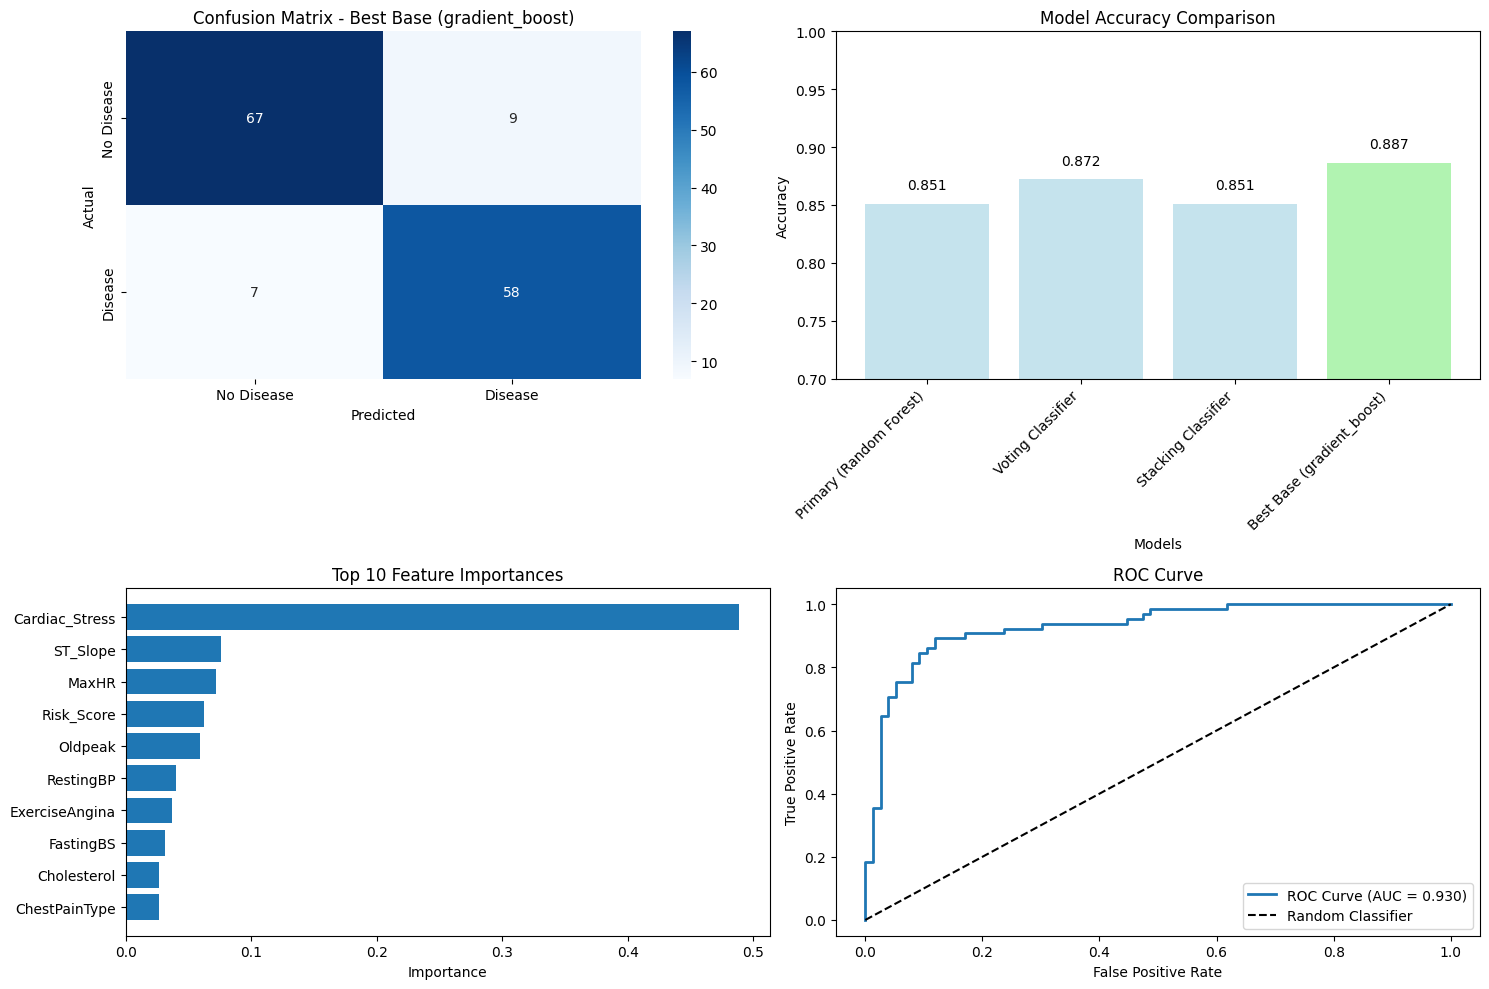

🎯 PROJECT SUMMARY
Original Size: (918, 12)
Processed Size: (701, 16)
Best Model: Best Base (gradient_boost)
Best Test Accuracy: 0.8865
ROC-AUC Score: 0.9302
 Ensemble methods (Base Learners, Voting, Stacking) implemented!


In [ ]:

print("\n TASK 9: Model Performance Evaluation ")

# Final evaluation on test set
y_pred_best = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate comprehensive metrics
accuracy = accuracy_score(y_test, y_pred_best)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred_best)


print(f"Best Model: {best_model_name}")
print(f"Test Set Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

print(f"\nConfusion Matrix:")
print(conf_matrix)

# Detailed metrics
TN, FP, FN, TP = conf_matrix.ravel()
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

print(f"\nDetailed Metrics:")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1_score:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_best))


print("\n=== VISUALIZATION ===")


plt.figure(figsize=(15, 10))


plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')


plt.subplot(2, 2, 2)
models = list(models_comparison.keys())
accuracies = list(models_comparison.values())
colors = ['lightblue' if model != best_model_name else 'lightgreen' for model in models]

bars = plt.bar(models, accuracies, color=colors, alpha=0.7)
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.7, 1.0)


for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{accuracy:.3f}', ha='center', va='bottom')


if hasattr(best_model.named_steps.get('classifier', None), 'feature_importances_'):
    plt.subplot(2, 2, 3)
    feature_importances = best_model.named_steps['classifier'].feature_importances_
    feature_names = X.columns

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values('importance', ascending=True).tail(10)

    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.title('Top 10 Feature Importances')
    plt.xlabel('Importance')


plt.subplot(2, 2, 4)
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()


print("🎯 PROJECT SUMMARY")

print(f"Original Size: {data.shape}")
print(f"Processed Size: {df.shape}")
print(f"Best Model: {best_model_name}")
print(f"Best Test Accuracy: {best_accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")


print(" Ensemble methods (Base Learners, Voting, Stacking) implemented!")


In [ ]:
import pickle
from google.colab import files

# Save the best_model to a .pkl file
model_filename = 'heart_disease_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Model saved as {model_filename}")

# Provide a download link
files.download(model_filename)

Model saved as heart_disease_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>